# Variational Autoencoder (VAE)

In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.initializers as I
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# The following code fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from lfw_dataset import fetch_lfw_dataset

data, attrs = fetch_lfw_dataset()

In [3]:
X_train = data[:10000].reshape((10000, -1))
print(X_train.shape)
X_val = data[10000:].reshape((-1, X_train.shape[1]))
print(X_val.shape)

image_h = data.shape[1]
image_w = data.shape[2]

(10000, 6075)
(3143, 6075)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [4]:
X_train = np.float32(X_train)
X_train = X_train/255
X_val = np.float32(X_val)
X_val = X_val/255

In [5]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

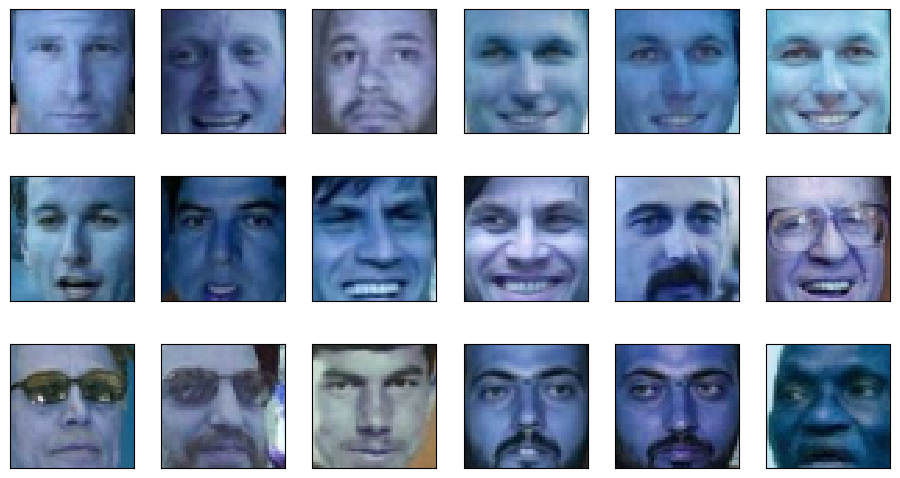

In [6]:
plot_gallery(X_train, image_h, image_w)

In [7]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, rate):
        super(DisplayCallback, self).__init__()
        self.model = model
        self.rate = rate

    def on_epoch_end(self, epoch, logs=None):
        model = self.model
        if epoch % self.rate == 0:
            idx = np.random.choice(X_train.shape[0])
            plt.subplot(221)
            plt.imshow(X_train[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(222)
            plt.imshow(tf.reshape(
                model(X_train[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            idx = np.random.choice(X_val.shape[0])
            plt.subplot(223)
            plt.imshow(X_val[idx].reshape(
                (image_h, image_w, 3)
            ))
            plt.subplot(224)
            plt.imshow(tf.reshape(
                model(X_val[tf.newaxis, idx]), (image_h, image_w, 3)
            ))
            plt.show()

Plot your loss values (also metrics, if you used them) for train and validation data

# Homework: Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler**, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [8]:
dimZ = 100
dimX = X_train.shape[1]

# Connect the encoder and decoder
input_encoder = L.Input((dimX, ), name="encoder_input")
common_layer = L.Dense(400, name="common_layer")(input_encoder)
mean_layer = L.Dense(dimZ, name="mean_layer")(common_layer)
logvar_layer = L.Dense(dimZ, name="logvar_layer")(common_layer)

# # Reparametrization trick
def sampling(mu, std):
    dimZ = mu.shape[1]
    epsilon = tf.keras.backend.random_normal(shape=(dimZ,), mean=0, stddev=1)
    return mu + tf.exp(std) * epsilon

z = sampling(mean_layer, logvar_layer)

# # Decoder
input_decoder = L.Input((dimZ,), name="decoder_input")
decoder_layer = L.Dense(dimX, name="decoder_layer", activation="sigmoid")(input_decoder)

# # Define the VAE model
encoder = tf.keras.Model(input_encoder, [mean_layer, logvar_layer])  # Return mean and log variance
decoder = tf.keras.Model(input_decoder, decoder_layer)

# # Combine the encoder and decoder
output_decoder = decoder(z)
vae = tf.keras.Model(input_encoder, output_decoder)

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)=...$$

In [9]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

        self.global_loss = tf.keras.metrics.Mean(name="loss")

    @tf.function
    def KL_divergence(self, mu, logsigma):
        return -0.5 * tf.reduce_sum(1 + logsigma - tf.square(mu) - tf.exp(logsigma))

    @tf.function
    def log_likelihood(self, x, z):
        return tf.reduce_mean(tf.square(x - z))
    
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            self.mu, self.logstd = self.encoder(x)

            z = self.decoder(self.mu, self.logstd)
            loss = self.KL_divergence(self.mu, self.logstd) + self.log_likelihood(y, z)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.global_loss.update_state(loss)

        return {
            "loss": self.global_loss.result()
        }

In [10]:
device = tf.device('GPU:0' if tf.config.list_physical_devices('GPU') else 'CPU')

with device: # Using GPU
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=tf.keras.optimizers.Adam())

And train the model:

In [11]:
history = vae.fit(
    X_train,
    X_train,
    epochs=35,
)

Epoch 1/30
313/313 [==============================] - 2s 3ms/step - loss: 235364.5469
Epoch 2/30
313/313 [==============================] - 1s 3ms/step - loss: 12701.9619
Epoch 3/30
313/313 [==============================] - 1s 3ms/step - loss: 11631.4707
Epoch 4/30
313/313 [==============================] - 1s 3ms/step - loss: 12109.8682
Epoch 5/30
313/313 [==============================] - 1s 3ms/step - loss: 9332.8486
Epoch 6/30
313/313 [==============================] - 1s 3ms/step - loss: 9891.3945
Epoch 7/30
313/313 [==============================] - 1s 3ms/step - loss: 10535.2344
Epoch 8/30
313/313 [==============================] - 1s 3ms/step - loss: 13271.0840
Epoch 9/30
313/313 [==============================] - 1s 3ms/step - loss: 14295.1201
Epoch 10/30
313/313 [==============================] - 1s 3ms/step - loss: 11891.8281
Epoch 11/30
313/313 [==============================] - 1s 3ms/step - loss: 11051.2168
Epoch 12/30
313/313 [==============================] - 1s 3ms/st

Plot the learning curves

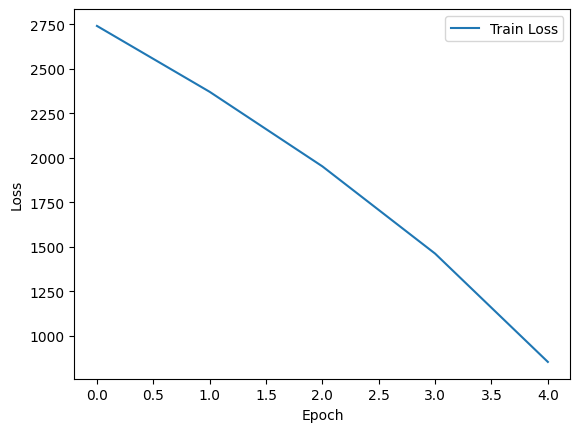

In [16]:
loss = history.history['loss']

epochs = range(len(loss))
plt.plot(epochs, loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

And finally sample from VAE.

# 1) Sample z ~ N(0,1)

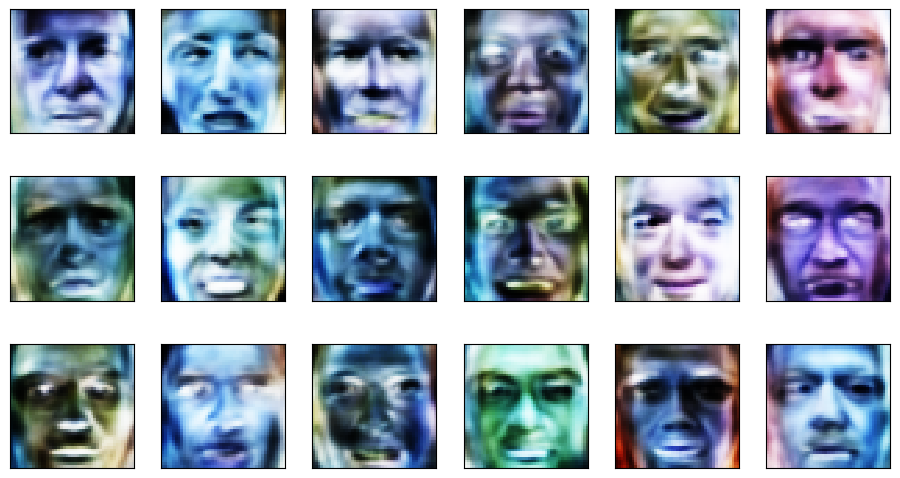

In [17]:
z = tf.keras.backend.random_normal(mean=0, stddev=1, shape=(18, dimZ))
output = vae.decoder(z).numpy()
plot_gallery(output, image_h, image_w, n_row=3, n_col=6)